### Image classification with CNNs for Food101 dataset

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import mlxtend
!pip install -q torchmetrics
import torchmetrics

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

import pandas as pd
import random

from tqdm.auto import tqdm
from timeit import default_timer as timer

print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"mlxtend: {mlxtend.__version__}")
print(f"torchmetrics: {torchmetrics.__version__}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.3 MB/s eta 0:00:00
torch: 2.1.0+cu118
torchvision: 0.16.0+cu118
mlxtend: 0.22.0
torchmetrics: 1.2.0


In [2]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Getting the Food101 dataset

In [4]:
data_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

In [5]:
torch.manual_seed(318)
train_data = datasets.Food101(root = "data",
                              split = "train",
                              download = True,
                              transform = data_transform,
                              target_transform = None)
test_data = datasets.Food101(root = "data",
                             split = "test",
                             download = True,
                             transform = data_transform,
                             target_transform = None)

100%|██████████| 4996278331/4996278331 [00:20<00:00, 243536342.62it/s]


Extracting data/food-101.tar.gz to data


In [6]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset Food101
    Number of datapoints: 75750
    Root location: data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset Food101
    Number of datapoints: 25250
    Root location: data
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [7]:
test_data_targets = []
for i in test_data:
  test_data_targets.append(i[1])

test_data_targets = torch.tensor(test_data_targets)
test_data_targets

tensor([23, 23, 23,  ..., 69, 69, 69])

In [8]:
#resize for InceptionV3 model
data_transform_iv3 = transforms.Compose([transforms.Resize(size=(299,299)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
torch.manual_seed(318)
train_data_iv3 = datasets.Food101(root = "data",
                              split = "train",
                              download = True,
                              transform = data_transform_iv3,
                              target_transform = None)
test_data_iv3 = datasets.Food101(root = "data",
                             split = "test",
                             download = True,
                             transform = data_transform_iv3,
                             target_transform = None)

BATCH_SIZE = 32

train_dataloader_iv3 = DataLoader(train_data_iv3,
                              batch_size = BATCH_SIZE,
                              num_workers=1,
                              shuffle = True)

test_dataloader_iv3 = DataLoader(test_data_iv3,
                             batch_size = BATCH_SIZE,
                             num_workers=1,
                             shuffle = False)

In [9]:
#plt.imshow(test_data[0][0].squeeze().permute(1,2,0))

In [10]:
len(train_data), len(test_data)

(75750, 25250)

In [11]:
len(train_data.classes)

101

In [12]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

image shape: torch.Size([3, 224, 224])
image label: churros


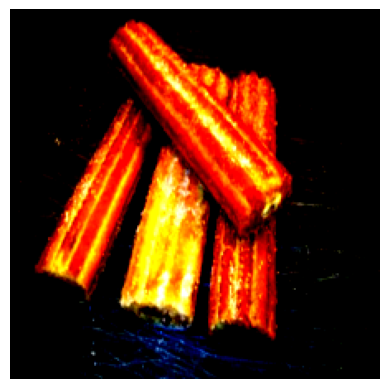

In [13]:
#check the shape of image

image, label = train_data[123]
print(f"image shape: {image.shape}")
print(f"image label: {class_names[label]}" )
plt.imshow(image.squeeze().permute(1,2,0))
plt.axis(False);

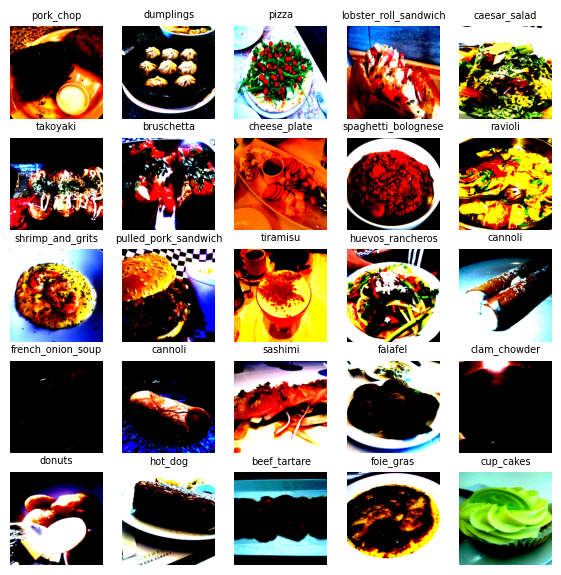

In [14]:
#plot more image
torch.manual_seed(318)
fig = plt.figure(figsize = (7,7))
rows, cols = 5,5
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze().permute(1,2,0))
  plt.title(class_names[label], fontsize=7)
  plt.axis(False);

In [15]:
train_data

Dataset Food101
    Number of datapoints: 75750
    Root location: data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [16]:
## 2. fit to DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size = BATCH_SIZE,
                              num_workers=1,
                              shuffle = True)

test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             num_workers=1,
                             shuffle = False)

In [17]:
print(f"length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

length of train_dataloader: 2368 batches of 32
length of test_dataloader: 790 batches of 32


In [18]:
img, label = next(iter(train_dataloader))
img.shape

torch.Size([32, 3, 224, 224])

# customise function

In [19]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    #put model to training mode
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")



In [20]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass (output raw logits)
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [21]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device=None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [22]:
def eval_mode(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device=device):
  loss, acc = 0,0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y,
                         y_pred = y_pred.argmax(dim=1))

    #Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [23]:
def CFMtensor(model: torch.nn.Module,
        data_loader = test_dataloader,
        test_data = test_data,
              test_data_targets = test_data_targets,
        device=device):
  y_preds = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader, desc="Making predictions..."):
      #send the data and targets to target device
      X, y = X.to(device), y.to(device)
      #do the forward pass
      y_logit = model(X)
      y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
      #put prediction on CPU for evaluation
      y_preds.append(y_pred.cpu())

  #concatenate list of predictions into a tensor
  #print(y_preds)
  y_pred_tensor=torch.cat(y_preds)

  from torchmetrics import ConfusionMatrix
  from mlxtend.plotting import plot_confusion_matrix


  #2. setup confusion imstance and compare predictions to targets
  confmat = ConfusionMatrix(num_classes=len(class_names),
                            task="multiclass")



  confmat_tensor = confmat(preds=y_pred_tensor,
                           target=test_data_targets)

  return confmat_tensor



In [24]:
def eval_model_CF(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              test_data = test_data,
              test_data_targets = test_data_targets,
              device=device):

  loss, acc = 0,0
  y_preds = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y,
                         y_pred = y_pred.argmax(dim=1))

      y_logit = model(X)
      y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
      #put prediction on CPU for evaluation
      y_preds.append(y_pred.cpu())

    #Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  #concatenate list of predictions into a tensor
  #print(y_preds)
  y_pred_tensor=torch.cat(y_preds)

  from torchmetrics import ConfusionMatrix
  from mlxtend.plotting import plot_confusion_matrix
  # setup confusion imstance and compare predictions to targets
  confmat = ConfusionMatrix(num_classes=len(class_names),
                            task="multiclass")
  confmat_tensor = confmat(preds=y_pred_tensor,
                           target=test_data_targets)


  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc} , confmat_tensor

# experimenting CNN: TinyVGG

In [25]:
class TinyVGGv0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block1 = nn.Sequential(nn.Conv2d(in_channels=input_shape,
                                               out_channels=hidden_units,
                                               kernel_size=3,
                                               stride=1,
                                               padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=hidden_units,
                                               out_channels=hidden_units,
                                               kernel_size=3,
                                               stride=1,
                                               padding=1),
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size = 2))
    self.conv_block2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                               out_channels=hidden_units,
                                               kernel_size=3,
                                               stride=1,
                                               padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=hidden_units,
                                               out_channels=hidden_units,
                                               kernel_size=3,
                                               stride=1,
                                               padding=1),
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size = 2))
    self.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(in_features = hidden_units*56*56,
                                               out_features = output_shape))


  def forward(self, X):
    X = self.conv_block1(X)
    X = self.conv_block2(X)
    #print(f"output shape of conv_block2: {X.shape}")
    X = self.classifier(X)
    return X

In [26]:
torch.manual_seed(318)
modelv0 = TinyVGGv0(input_shape = 3,
                      hidden_units = 10,
                      output_shape = len(class_names)).to(device)

In [27]:
# loss function, optimizer, and accuracy function

from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = modelv0.parameters(),
                            lr = 0.1)

In [28]:
'''torch.manual_seed(318)
torch.cuda.manual_seed(318)

# Measure time
from timeit import default_timer as timer
train_time_start_modelv0 = timer()

#train and test model
epochs =3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_step(model=modelv0,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=modelv0,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_modelv0 = timer()
total_train_time_modelv0 = print_train_time(start=train_time_start_modelv0,
                                               end=train_time_end_modelv0,
                                               device=device)
'''

'torch.manual_seed(318)\ntorch.cuda.manual_seed(318)\n\n# Measure time\nfrom timeit import default_timer as timer\ntrain_time_start_modelv0 = timer()\n\n#train and test model\nepochs =3\nfor epoch in tqdm(range(epochs)):\n  print(f"Epoch: {epoch}")\n  train_step(model=modelv0,\n             data_loader=train_dataloader,\n             loss_fn=loss_fn,\n             optimizer=optimizer,\n             accuracy_fn=accuracy_fn,\n             device=device)\n  test_step(model=modelv0,\n            data_loader=test_dataloader,\n            loss_fn=loss_fn,\n            accuracy_fn=accuracy_fn,\n            device=device)\n\ntrain_time_end_modelv0 = timer()\ntotal_train_time_modelv0 = print_train_time(start=train_time_start_modelv0,\n                                               end=train_time_end_modelv0,\n                                               device=device)\n'

## Pre-trained models:

In [29]:
from torchvision.models import efficientnet_b0 , EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model = efficientnet_b0(weights="DEFAULT")
model_efficientnetb0 = model
#weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
#model = torchvision.models.efficientnet_b0(weights=weights)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s] 


In [30]:
# Print a summary using torchinfo (uncomment for actual output)
!pip install torchinfo
import torchinfo
torchinfo.summary(model=model_efficientnetb0,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [31]:
#model_efficientnetb0

In [32]:
torch.manual_seed(318)
torch.cuda.manual_seed(318)

for param in model_efficientnetb0.features.parameters():
    param.requires_grad = False

output_shape = len(class_names)
model_efficientnetb0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

torchinfo.summary(model_efficientnetb0,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 101]            --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [33]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
model_resnet50 = torchvision.models.resnet50(weights=weights)
torchinfo.summary(model=model_resnet50,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 289MB/s]


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [34]:
#model_resnet50

In [35]:
torch.manual_seed(318)
torch.cuda.manual_seed(318)

for param in model_resnet50.conv1.parameters():
    param.requires_grad = False
for param in model_resnet50.bn1.parameters():
    param.requires_grad = False
for param in model_resnet50.layer1.parameters():
    param.requires_grad = False
for param in model_resnet50.layer2.parameters():
    param.requires_grad = False
for param in model_resnet50.layer3.parameters():
    param.requires_grad = False
for param in model_resnet50.layer4.parameters():
    param.requires_grad = False

model_resnet50.fc = nn.Linear(in_features=2048,
                              out_features = output_shape,
                              bias=True).to(device)

torchinfo.summary(model=model_resnet50,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 101]            --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [36]:
weights = torchvision.models.Inception_V3_Weights.DEFAULT
model_inceptionv3 = torchvision.models.inception_v3(weights=weights)
torchinfo.summary(model=model_inceptionv3,
        input_size=(32, 3, 299, 299), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 296MB/s] 


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Inception3 (Inception3)                  [32, 3, 299, 299]    [32, 1000]           3,326,696            True
├─BasicConv2d (Conv2d_1a_3x3)            [32, 3, 299, 299]    [32, 32, 149, 149]   --                   True
│    └─Conv2d (conv)                     [32, 3, 299, 299]    [32, 32, 149, 149]   864                  True
│    └─BatchNorm2d (bn)                  [32, 32, 149, 149]   [32, 32, 149, 149]   64                   True
├─BasicConv2d (Conv2d_2a_3x3)            [32, 32, 149, 149]   [32, 32, 147, 147]   --                   True
│    └─Conv2d (conv)                     [32, 32, 149, 149]   [32, 32, 147, 147]   9,216                True
│    └─BatchNorm2d (bn)                  [32, 32, 147, 147]   [32, 32, 147, 147]   64                   True
├─BasicConv2d (Conv2d_2b_3x3)            [32, 32, 147, 147]   [32, 64, 147, 147]   --                   True
│    └─Conv2d 

In [37]:
model_inceptionv3

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [38]:
torch.manual_seed(318)
torch.cuda.manual_seed(318)

model_inceptionv3.aux_logits = False

for param in model_inceptionv3.Conv2d_1a_3x3.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Conv2d_2a_3x3.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Conv2d_2b_3x3.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Conv2d_3b_1x1.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Conv2d_4a_3x3.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Mixed_5b.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Mixed_5c.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Mixed_5d.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Mixed_6a.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Mixed_6b.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Mixed_6c.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Mixed_6d.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Mixed_6e.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Mixed_7a.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Mixed_7b.parameters():
    param.requires_grad = False
for param in model_inceptionv3.Mixed_7c.parameters():
    param.requires_grad = False

model_inceptionv3.fc = nn.Linear(in_features=2048,
                                 out_features=output_shape
                                 , bias=True).to(device)

torchinfo.summary(model=model_inceptionv3,
        input_size=(32, 3, 299, 299), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Inception3 (Inception3)                  [32, 3, 299, 299]    [32, 101]            3,326,696            Partial
├─BasicConv2d (Conv2d_1a_3x3)            [32, 3, 299, 299]    [32, 32, 149, 149]   --                   False
│    └─Conv2d (conv)                     [32, 3, 299, 299]    [32, 32, 149, 149]   (864)                False
│    └─BatchNorm2d (bn)                  [32, 32, 149, 149]   [32, 32, 149, 149]   (64)                 False
├─BasicConv2d (Conv2d_2a_3x3)            [32, 32, 149, 149]   [32, 32, 147, 147]   --                   False
│    └─Conv2d (conv)                     [32, 32, 149, 149]   [32, 32, 147, 147]   (9,216)              False
│    └─BatchNorm2d (bn)                  [32, 32, 147, 147]   [32, 32, 147, 147]   (64)                 False
├─BasicConv2d (Conv2d_2b_3x3)            [32, 32, 147, 147]   [32, 64, 147, 147]   --                   False
│   

In [39]:
##train the pre-trained models

In [40]:
lr = 1e-2

In [41]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_efficientnetb0.parameters(), lr=lr)

torch.manual_seed(318)
torch.cuda.manual_seed(318)

# Measure time
from timeit import default_timer as timer
train_time_start_model_efficientnetb0 = timer()

#train and test model
epochs =5
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_step(model=model_efficientnetb0,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_efficientnetb0,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_efficientnetb0 = timer()
total_train_time_model_efficientnetb0 = print_train_time(start=train_time_start_model_efficientnetb0,
                                               end=train_time_end_model_efficientnetb0,
                                               device=device)



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 4.03773 | Train accuracy: 33.77%
Test loss: 3.09488 | Test accuracy: 47.44%

Epoch: 1
Train loss: 4.29006 | Train accuracy: 38.89%
Test loss: 3.28812 | Test accuracy: 48.46%

Epoch: 2
Train loss: 4.45917 | Train accuracy: 39.74%
Test loss: 3.47480 | Test accuracy: 48.82%

Epoch: 3
Train loss: 4.52953 | Train accuracy: 40.71%
Test loss: 3.45604 | Test accuracy: 49.65%

Epoch: 4
Train loss: 4.61404 | Train accuracy: 40.99%
Test loss: 3.61765 | Test accuracy: 49.64%

Train time on cuda: 2360.310 seconds


  0%|          | 0/790 [00:00<?, ?it/s]

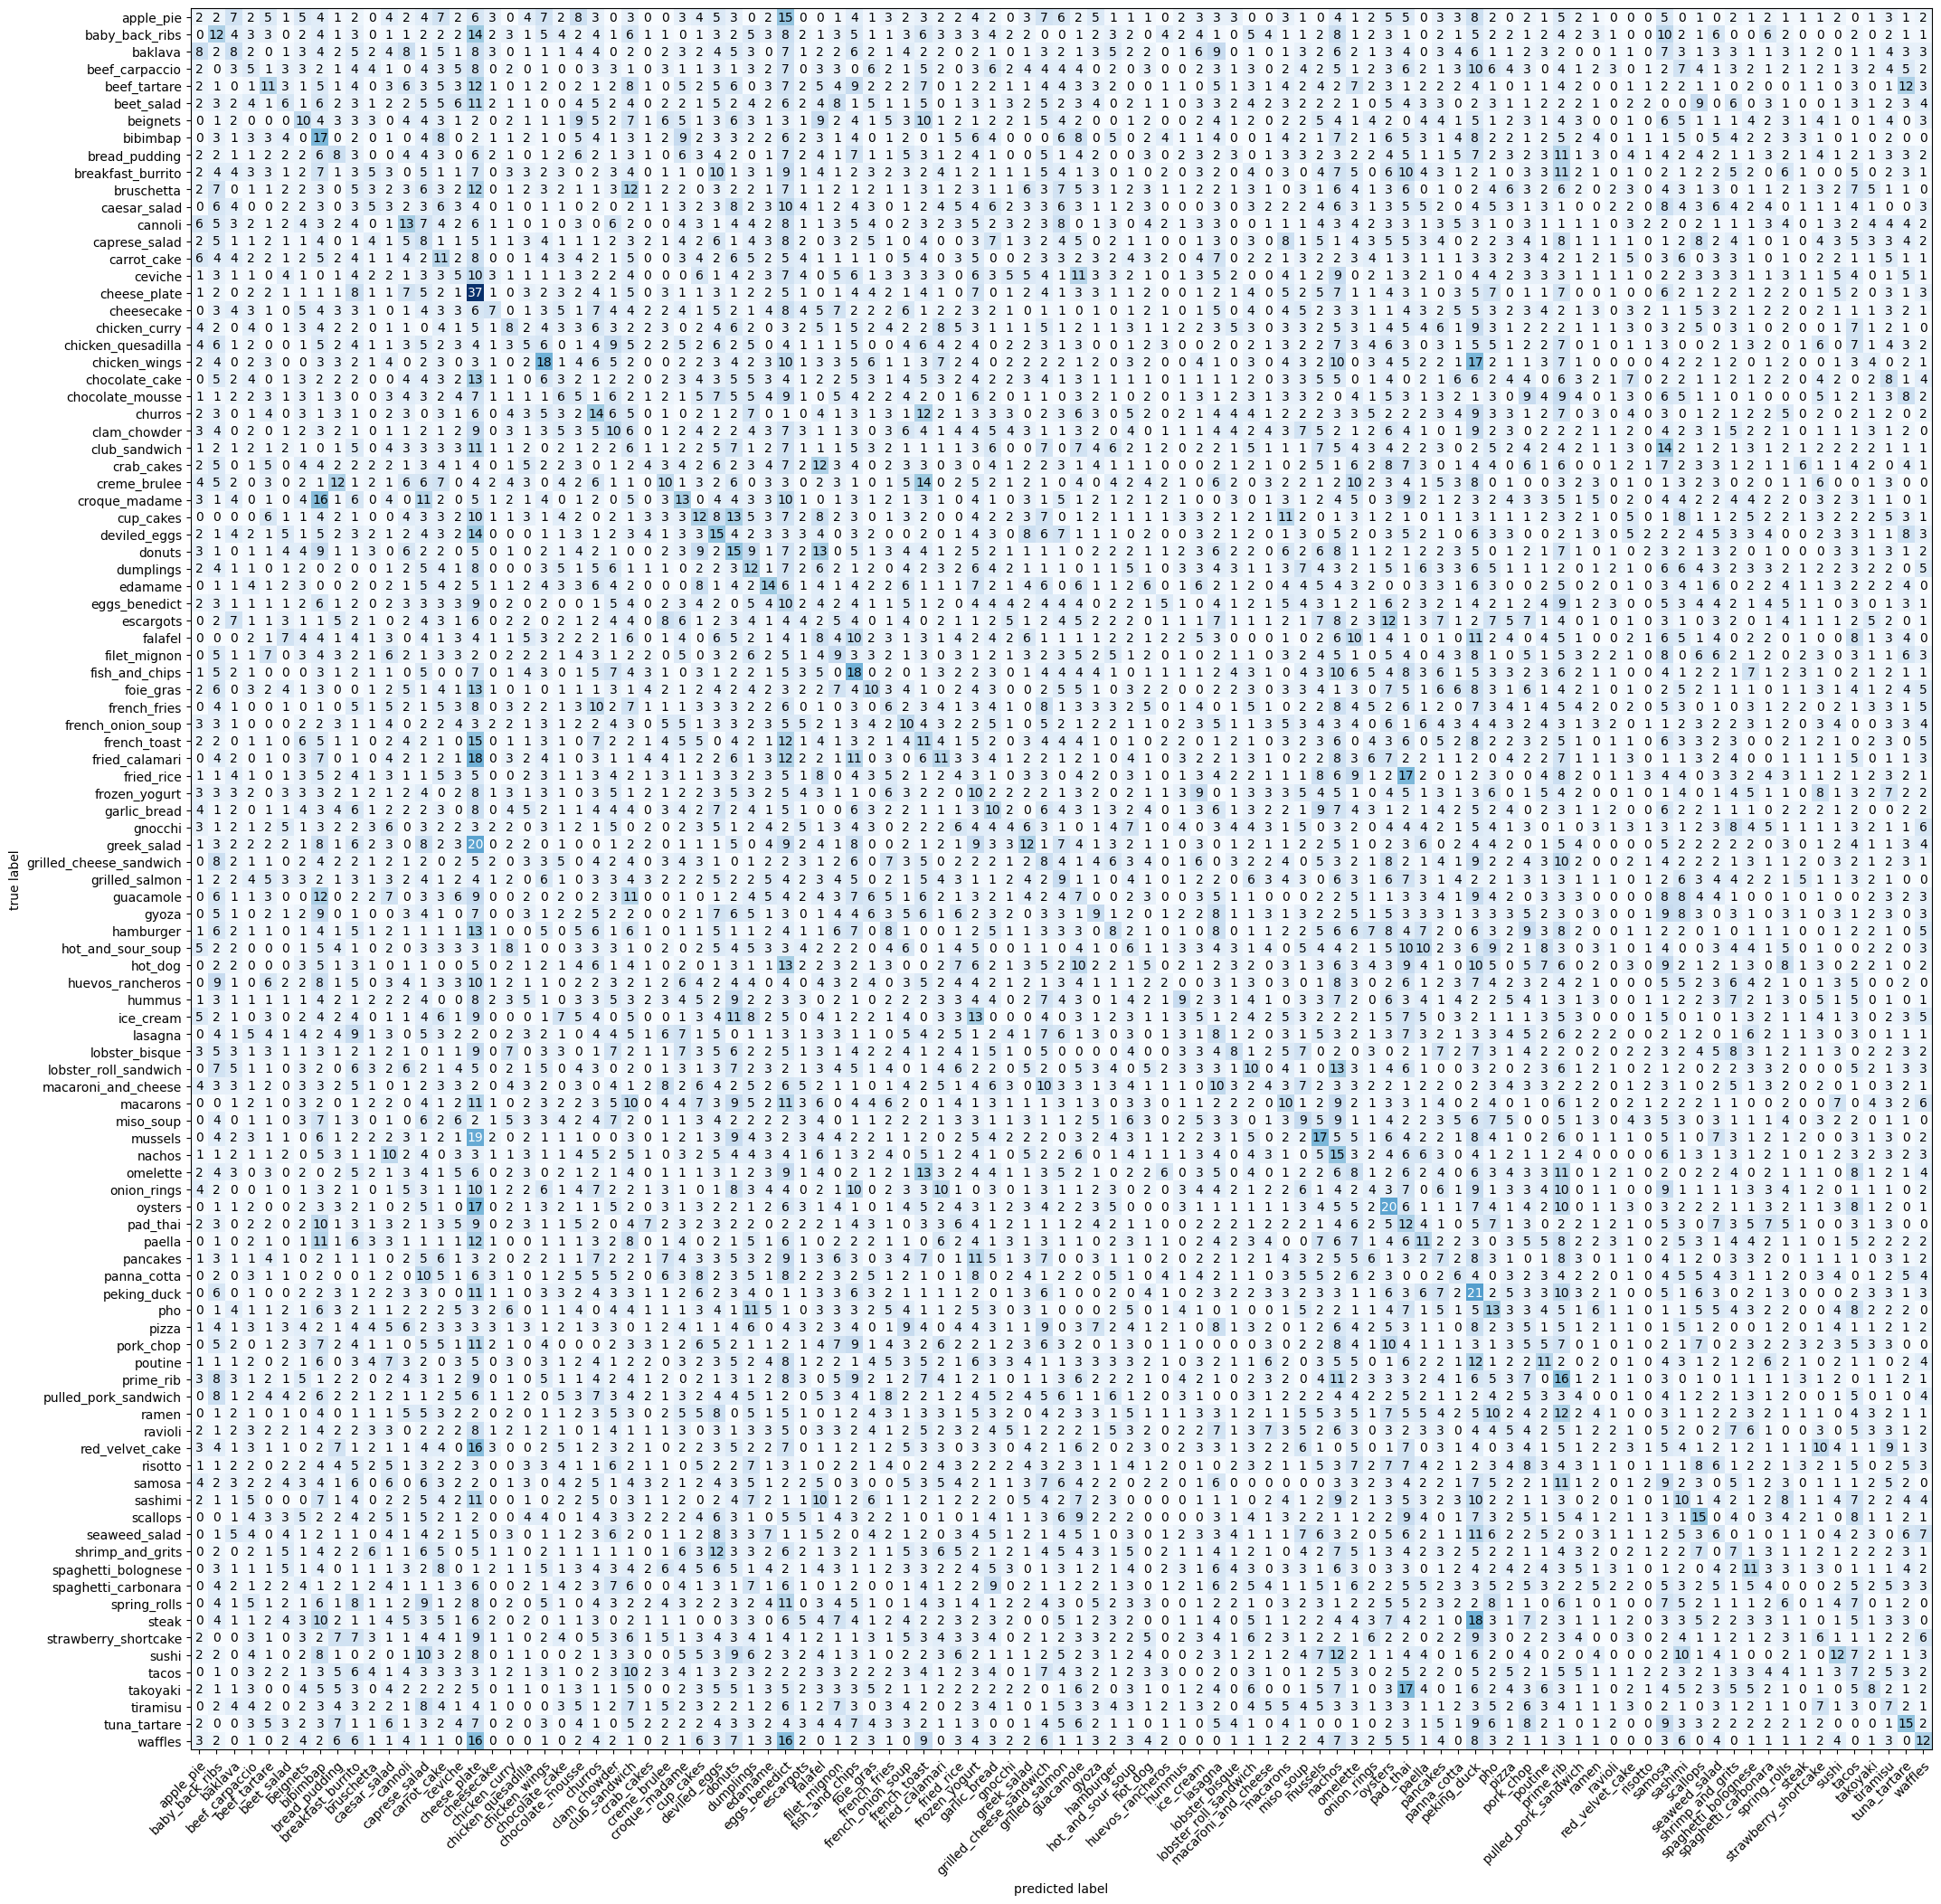

In [45]:
model_efficientnetb0_results, confmat_tensor_efficientnetb0 = eval_model_CF(model=model_efficientnetb0,
                                                                            data_loader = test_dataloader,
                                                                            loss_fn=loss_fn,
                                                                            accuracy_fn= accuracy_fn,
                                                                            test_data = test_data,
                                                                            test_data_targets = test_data_targets,
                                                                            device = device)


fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor_efficientnetb0.numpy(),
    class_names=class_names,
    figsize=(25,25))

In [46]:
model_efficientnetb0_results

{'model_name': 'EfficientNet',
 'model_loss': 3.6005733013153076,
 'model_acc': 49.56091772151899}

In [47]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=lr)

torch.manual_seed(318)
torch.cuda.manual_seed(318)

# Measure time
from timeit import default_timer as timer
train_time_start_model_resnet50 = timer()

#train and test model
epochs =5
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_step(model=model_resnet50,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_resnet50,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_resnet50 = timer()
total_train_time_model_resnet50 = print_train_time(start=train_time_start_model_resnet50,
                                               end=train_time_end_model_resnet50,
                                               device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 2.86651 | Train accuracy: 44.83%
Test loss: 2.29052 | Test accuracy: 56.29%

Epoch: 1
Train loss: 2.42889 | Train accuracy: 55.70%
Test loss: 2.45055 | Test accuracy: 56.99%

Epoch: 2
Train loss: 2.36013 | Train accuracy: 58.68%
Test loss: 2.87084 | Test accuracy: 56.71%

Epoch: 3
Train loss: 2.29187 | Train accuracy: 60.74%
Test loss: 2.91279 | Test accuracy: 57.27%

Epoch: 4
Train loss: 2.26839 | Train accuracy: 62.24%
Test loss: 3.21969 | Test accuracy: 56.59%

Train time on cuda: 2358.236 seconds


  0%|          | 0/790 [00:00<?, ?it/s]

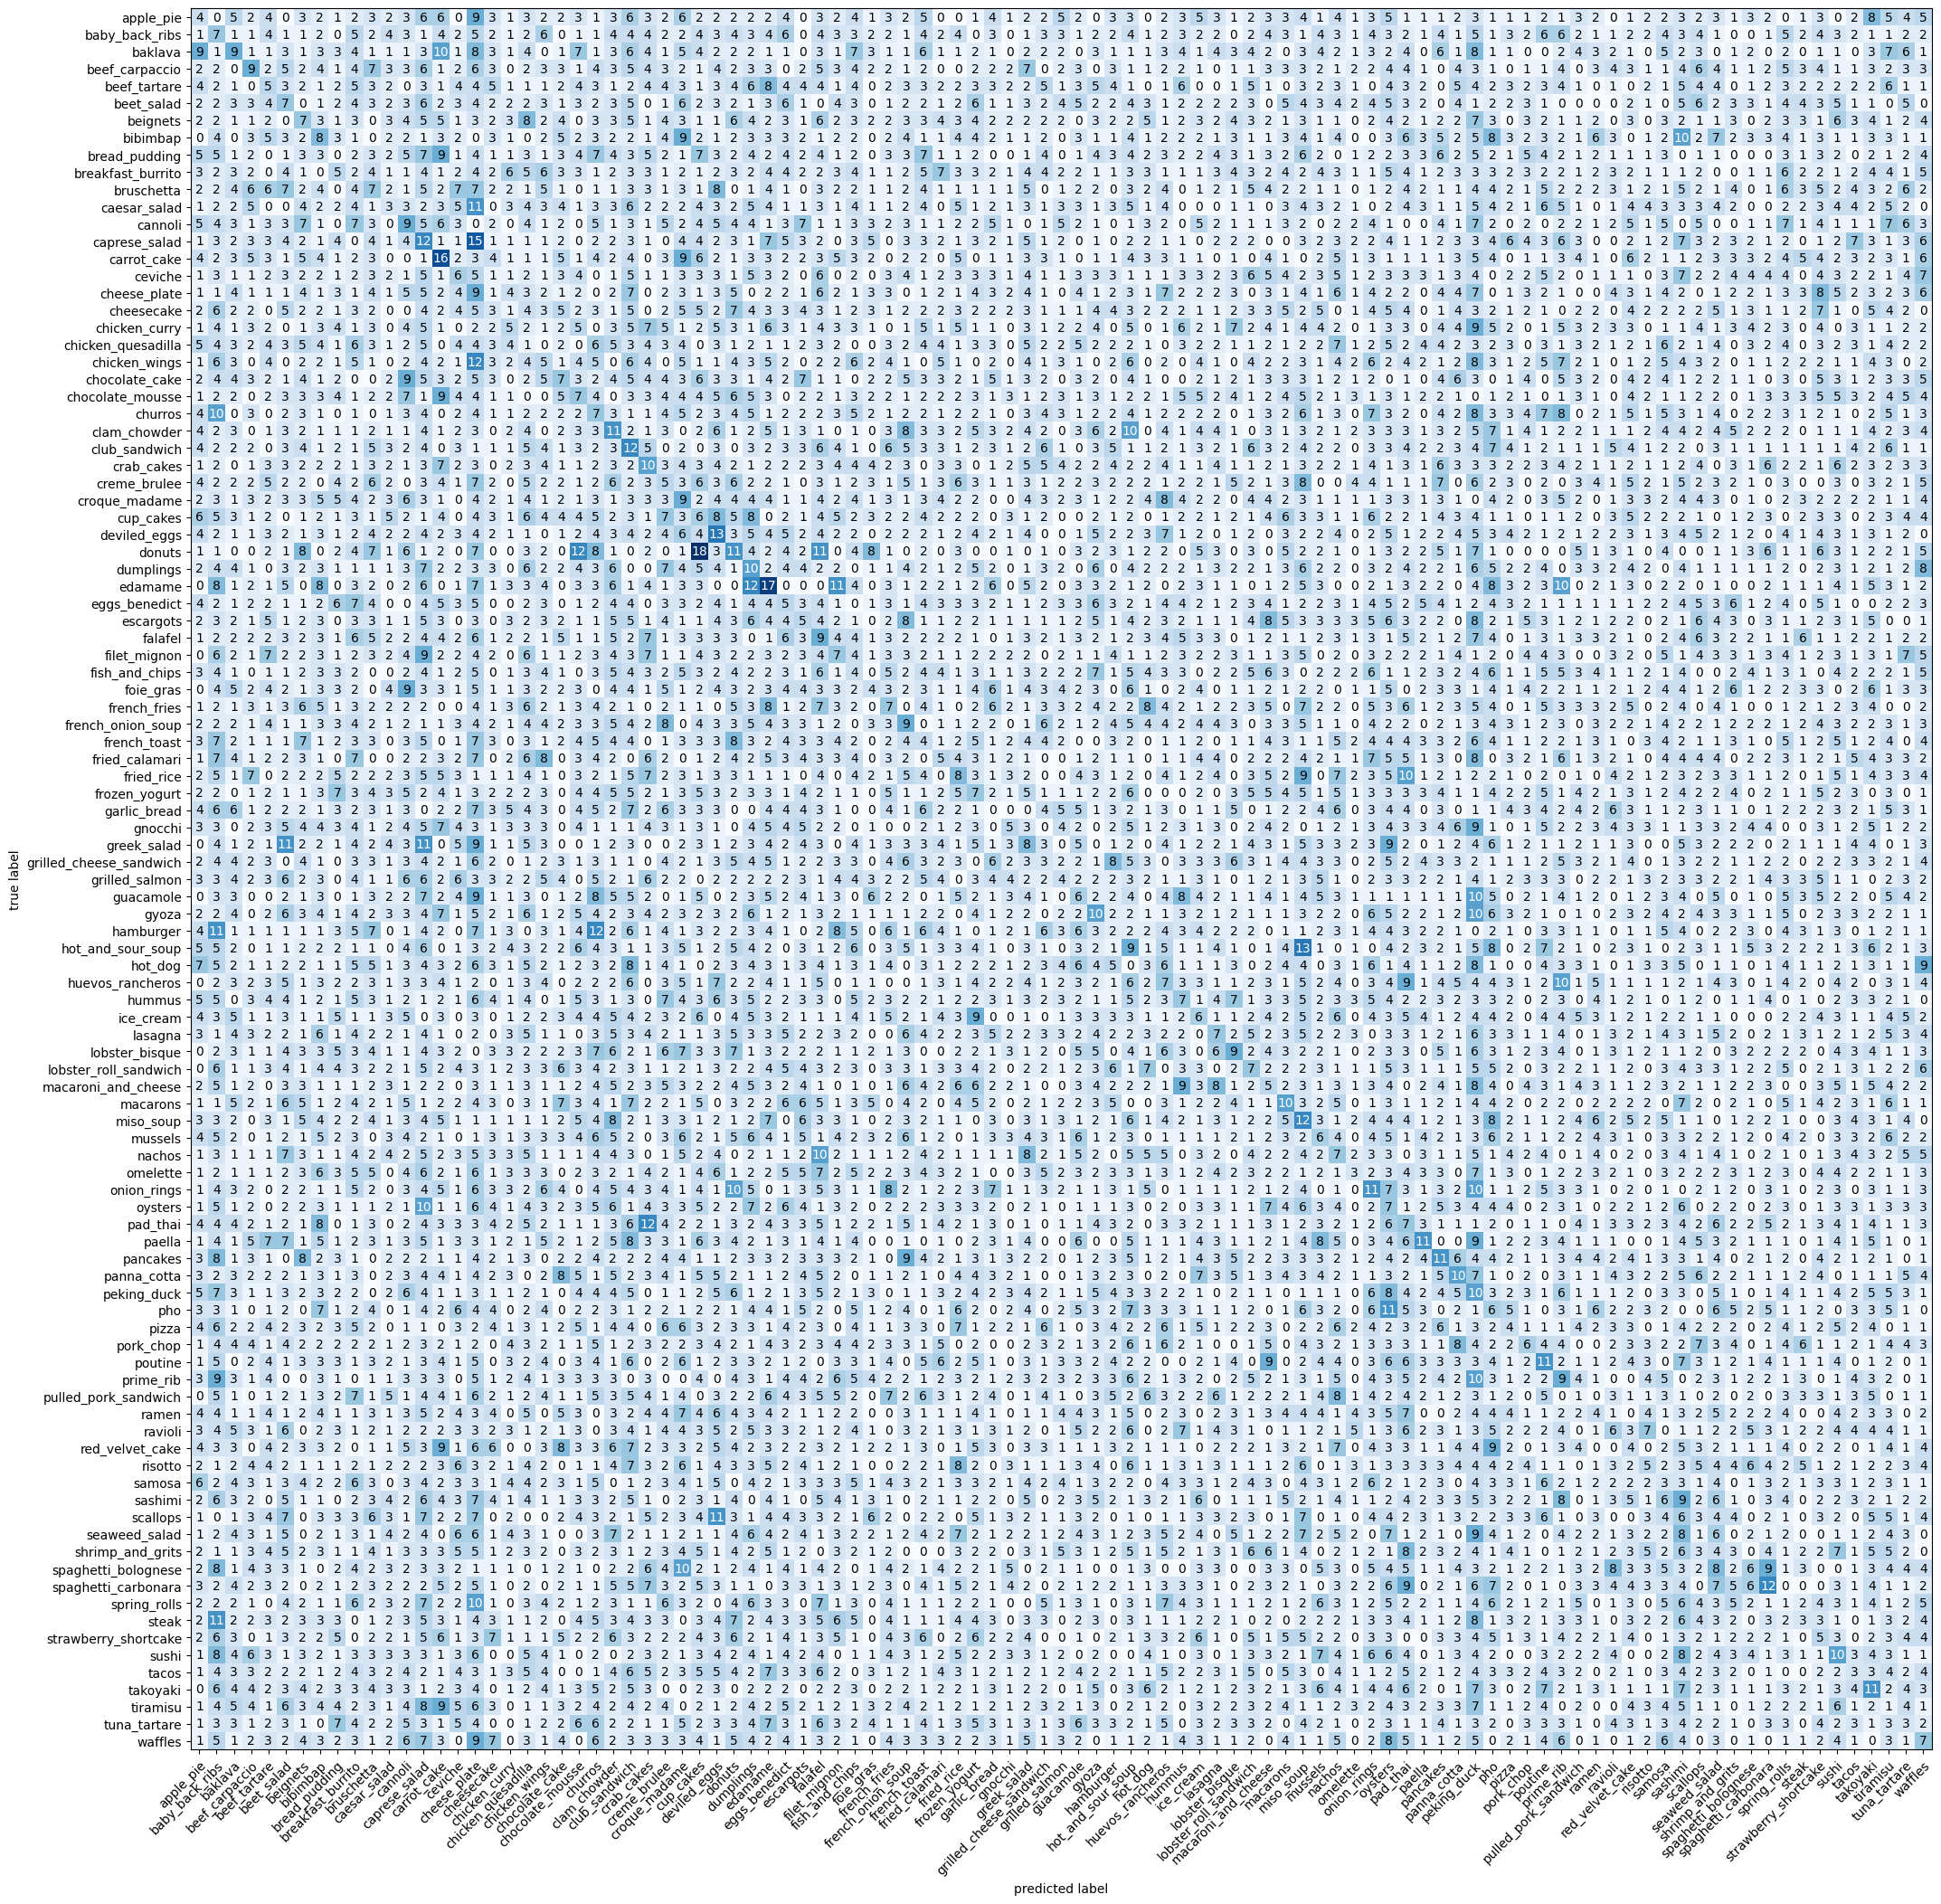

In [48]:
model_resnet50_results, confmat_tensor_resnet50 = eval_model_CF(model=model_resnet50,
                                                                            data_loader = test_dataloader,
                                                                            loss_fn=loss_fn,
                                                                            accuracy_fn= accuracy_fn,
                                                                            test_data = test_data,
                                                                            test_data_targets = test_data_targets,
                                                                            device = device)


fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor_resnet50.numpy(),
    class_names=class_names,
    figsize=(25,25))

In [49]:
model_resnet50_results

{'model_name': 'ResNet',
 'model_loss': 3.2292728424072266,
 'model_acc': 56.7128164556962}

In [50]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_inceptionv3.parameters(), lr=lr)

torch.manual_seed(318)
torch.cuda.manual_seed(318)

# Measure time
from timeit import default_timer as timer
train_time_start_model_inceptionv3 = timer()

#train and test model
epochs =5
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_step(model=model_inceptionv3,
             data_loader=train_dataloader_iv3,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_inceptionv3,
            data_loader=test_dataloader_iv3,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_inceptionv3 = timer()
total_train_time_model_inceptionv3 = print_train_time(start=train_time_start_model_inceptionv3,
                                               end=train_time_end_model_inceptionv3,
                                               device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 7.58019 | Train accuracy: 23.18%
Test loss: 5.32375 | Test accuracy: 39.47%

Epoch: 1
Train loss: 9.18813 | Train accuracy: 28.04%
Test loss: 5.35170 | Test accuracy: 43.92%

Epoch: 2
Train loss: 9.99403 | Train accuracy: 29.06%
Test loss: 5.65725 | Test accuracy: 44.51%

Epoch: 3
Train loss: 10.26824 | Train accuracy: 29.78%
Test loss: 6.10569 | Test accuracy: 43.56%

Epoch: 4
Train loss: 10.50333 | Train accuracy: 30.25%
Test loss: 6.20650 | Test accuracy: 43.32%

Train time on cuda: 2860.922 seconds


  0%|          | 0/790 [00:00<?, ?it/s]

{'model_name': 'Inception3', 'model_loss': 6.2077531814575195, 'model_acc': 43.18433544303797}


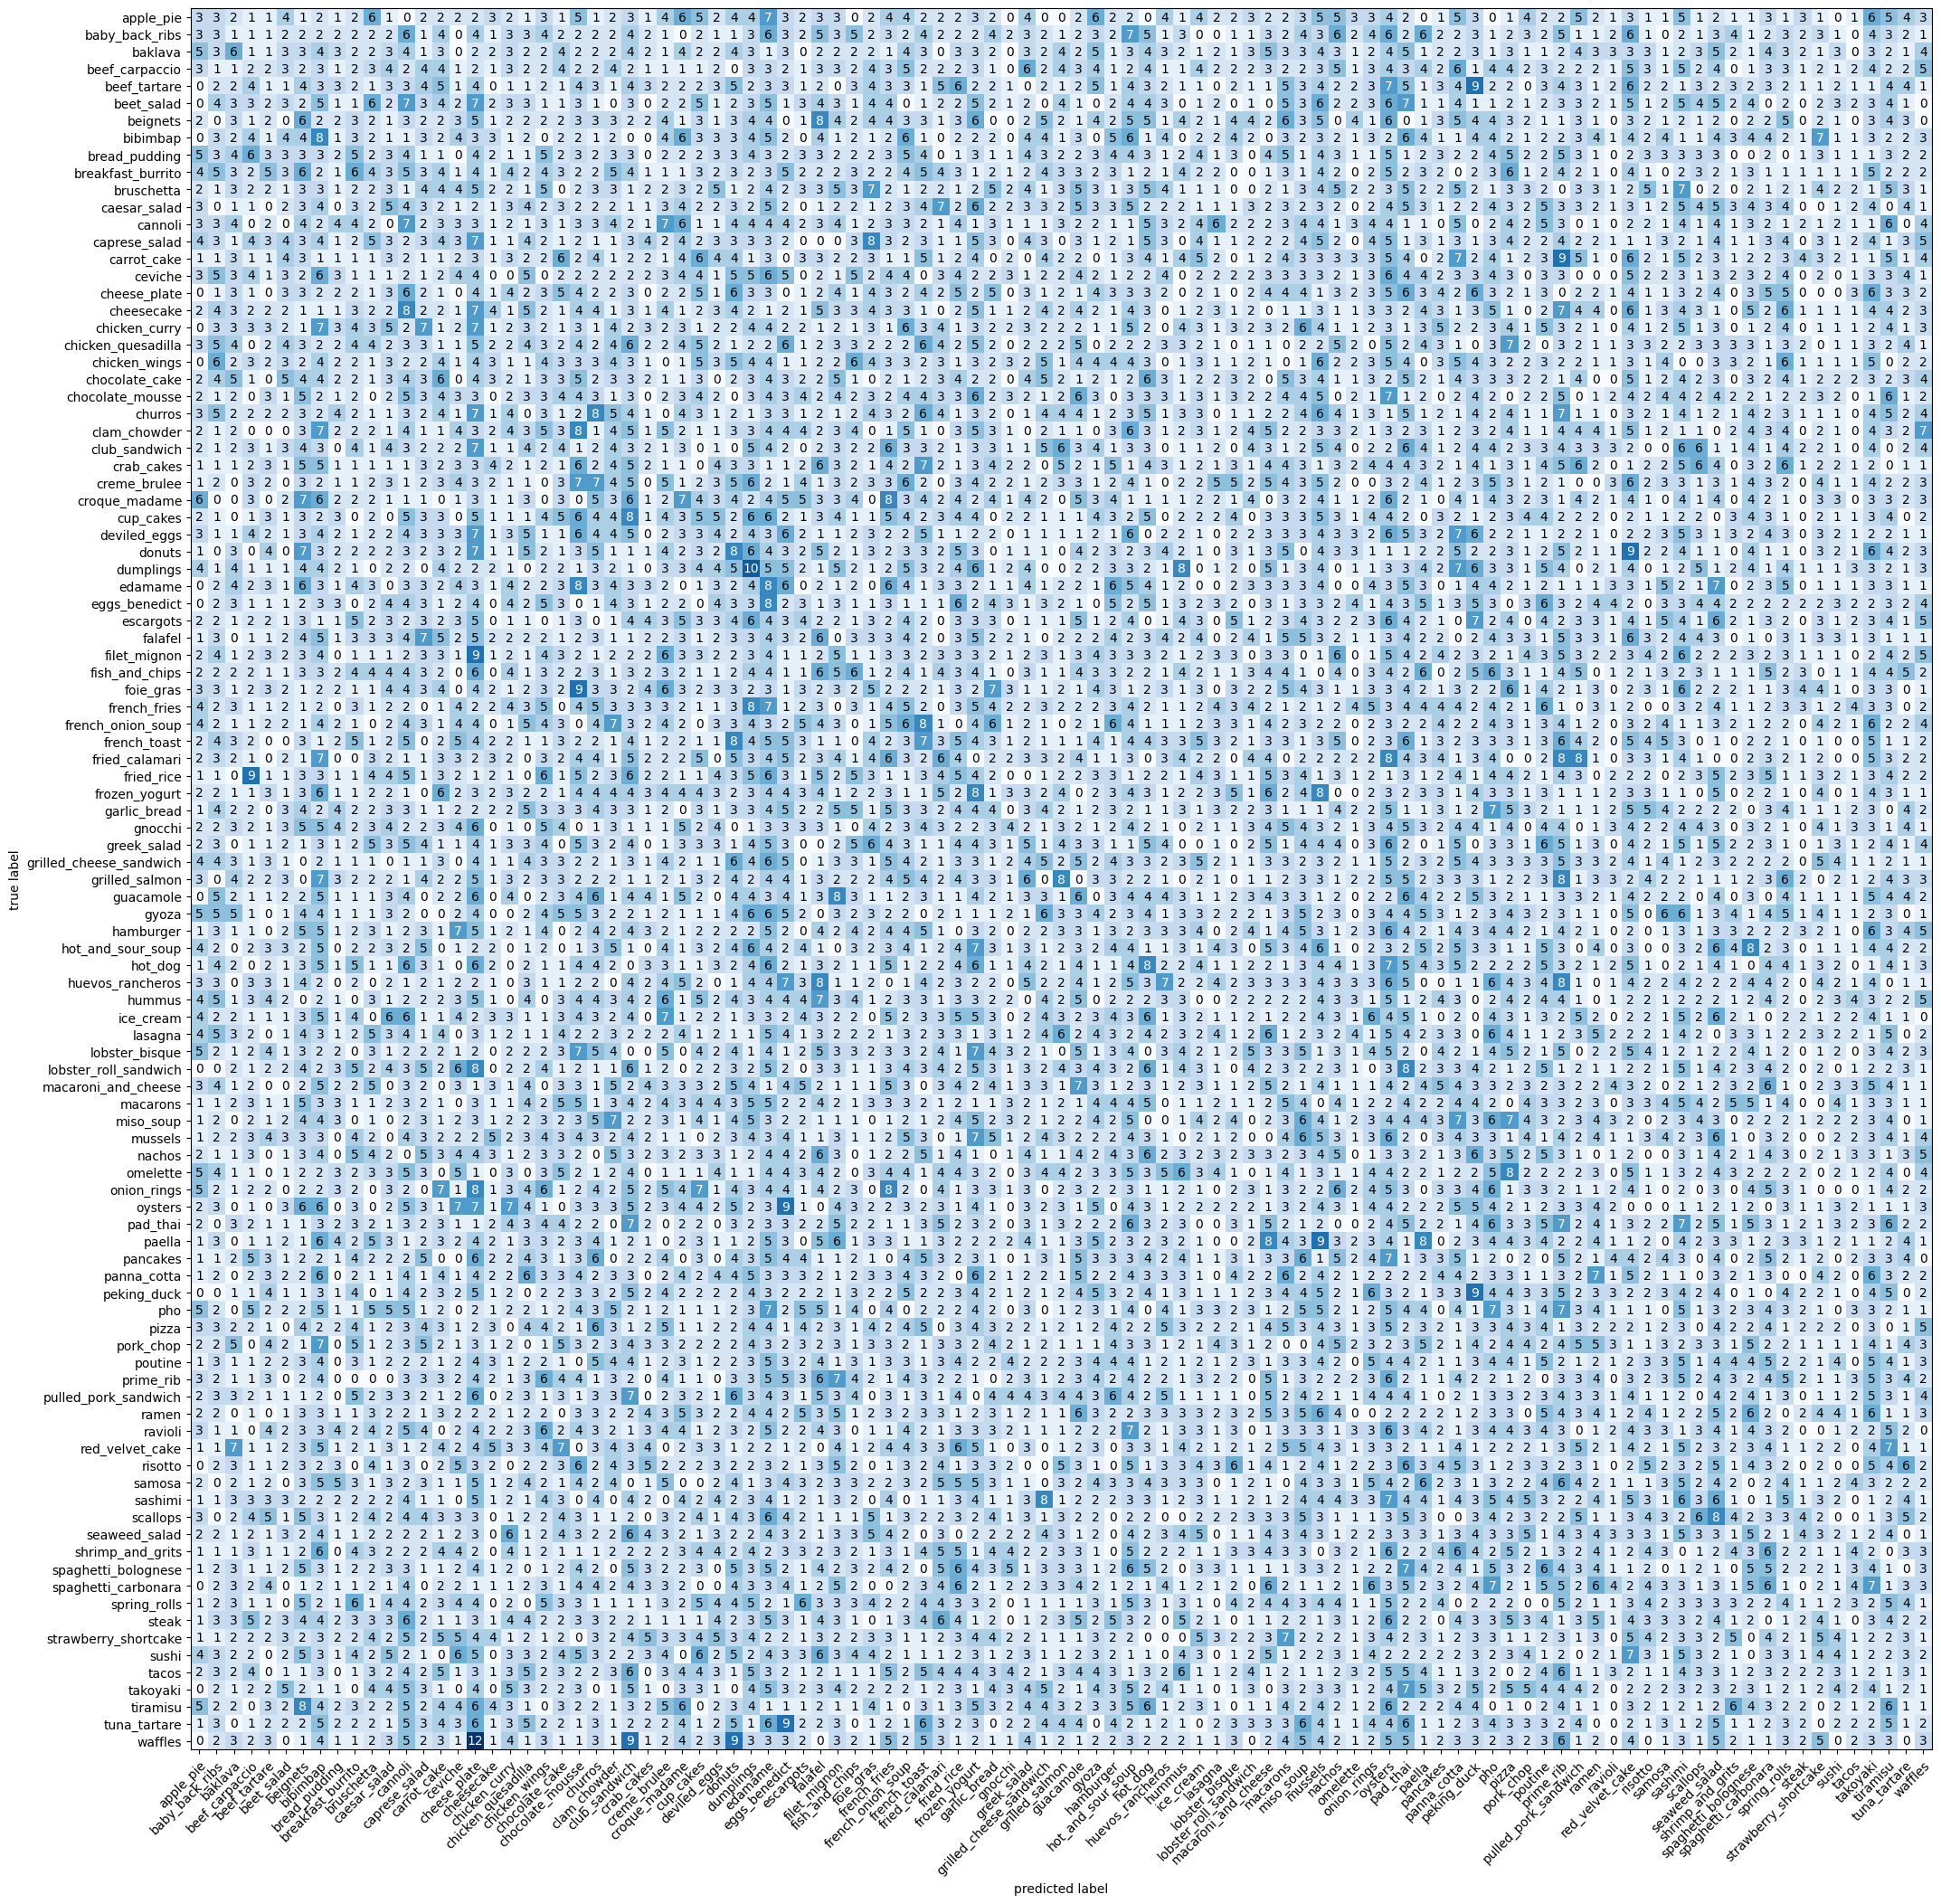

In [51]:
model_inceptionv3_results, confmat_tensor_inceptionv3 = eval_model_CF(model=model_inceptionv3,
                                                                            data_loader = test_dataloader_iv3,
                                                                            loss_fn=loss_fn,
                                                                            accuracy_fn= accuracy_fn,
                                                                            test_data = test_data_iv3,
                                                                            test_data_targets = test_data_targets,
                                                                            device = device)


fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor_inceptionv3.numpy(),
    class_names=class_names,
    figsize=(25,25))
print(model_inceptionv3_results)

In [52]:
#Saving the model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "Food101_InceptionV3_v0.pth"
MODEL_SAVE_PATH_InceptionV3 = MODEL_PATH/MODEL_NAME

print(f"saving model to: {MODEL_SAVE_PATH_InceptionV3}")
torch.save(obj=model_inceptionv3.state_dict(),
           f=MODEL_SAVE_PATH_InceptionV3)

MODEL_NAME = "Food101_EfficientNetB0_v0.pth"
MODEL_SAVE_PATH_EfficientnetB0 = MODEL_PATH/MODEL_NAME

print(f"saving model to: {MODEL_SAVE_PATH_EfficientnetB0}")
torch.save(obj=model_efficientnetb0.state_dict(),
           f=MODEL_SAVE_PATH_EfficientnetB0)

MODEL_NAME = "Food101_ResNet50_v0.pth"
MODEL_SAVE_PATH_Resnet50 = MODEL_PATH/MODEL_NAME

print(f"saving model to: {MODEL_SAVE_PATH_Resnet50}")
torch.save(obj=model_resnet50.state_dict(),
           f=MODEL_SAVE_PATH_Resnet50)


saving model to: models/Food101_InceptionV3_v0.pth
saving model to: models/Food101_EfficientNetB0_v0.pth
saving model to: models/Food101_ResNet50_v0.pth


In [53]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
model_resnet50v0 = torchvision.models.resnet50(weights=weights)

torch.manual_seed(318)
torch.cuda.manual_seed(318)

for param in model_resnet50v0.conv1.parameters():
    param.requires_grad = False
for param in model_resnet50v0.bn1.parameters():
    param.requires_grad = False
for param in model_resnet50v0.layer1.parameters():
    param.requires_grad = False
for param in model_resnet50v0.layer2.parameters():
    param.requires_grad = False
for param in model_resnet50v0.layer3.parameters():
    param.requires_grad = False
for param in model_resnet50v0.layer4.parameters():
    param.requires_grad = False

model_resnet50v0.fc = nn.Linear(in_features=2048,
                              out_features = output_shape,
                              bias=True).to(device)

from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet50v0.parameters(), lr=1e-3)

torch.manual_seed(318)
torch.cuda.manual_seed(318)

# Measure time
from timeit import default_timer as timer
train_time_start_model_resnet50v0 = timer()

#train and test model
epochs =5
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_step(model=model_resnet50v0,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_resnet50v0,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_resnet50v0 = timer()
total_train_time_model_resnet50v0 = print_train_time(start=train_time_start_model_resnet50v0,
                                               end=train_time_end_model_resnet50v0,
                                               device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 2.34368 | Train accuracy: 46.98%
Test loss: 1.55873 | Test accuracy: 61.34%

Epoch: 1
Train loss: 1.58372 | Train accuracy: 60.90%
Test loss: 1.37684 | Test accuracy: 64.91%

Epoch: 2
Train loss: 1.38380 | Train accuracy: 65.12%
Test loss: 1.31862 | Test accuracy: 65.70%

Epoch: 3
Train loss: 1.25953 | Train accuracy: 67.79%
Test loss: 1.27864 | Test accuracy: 66.46%

Epoch: 4
Train loss: 1.17484 | Train accuracy: 69.63%
Test loss: 1.28058 | Test accuracy: 66.15%

Train time on cuda: 2369.690 seconds


  0%|          | 0/790 [00:00<?, ?it/s]

{'model_name': 'ResNet', 'model_loss': 1.280983328819275, 'model_acc': 66.19066455696202}


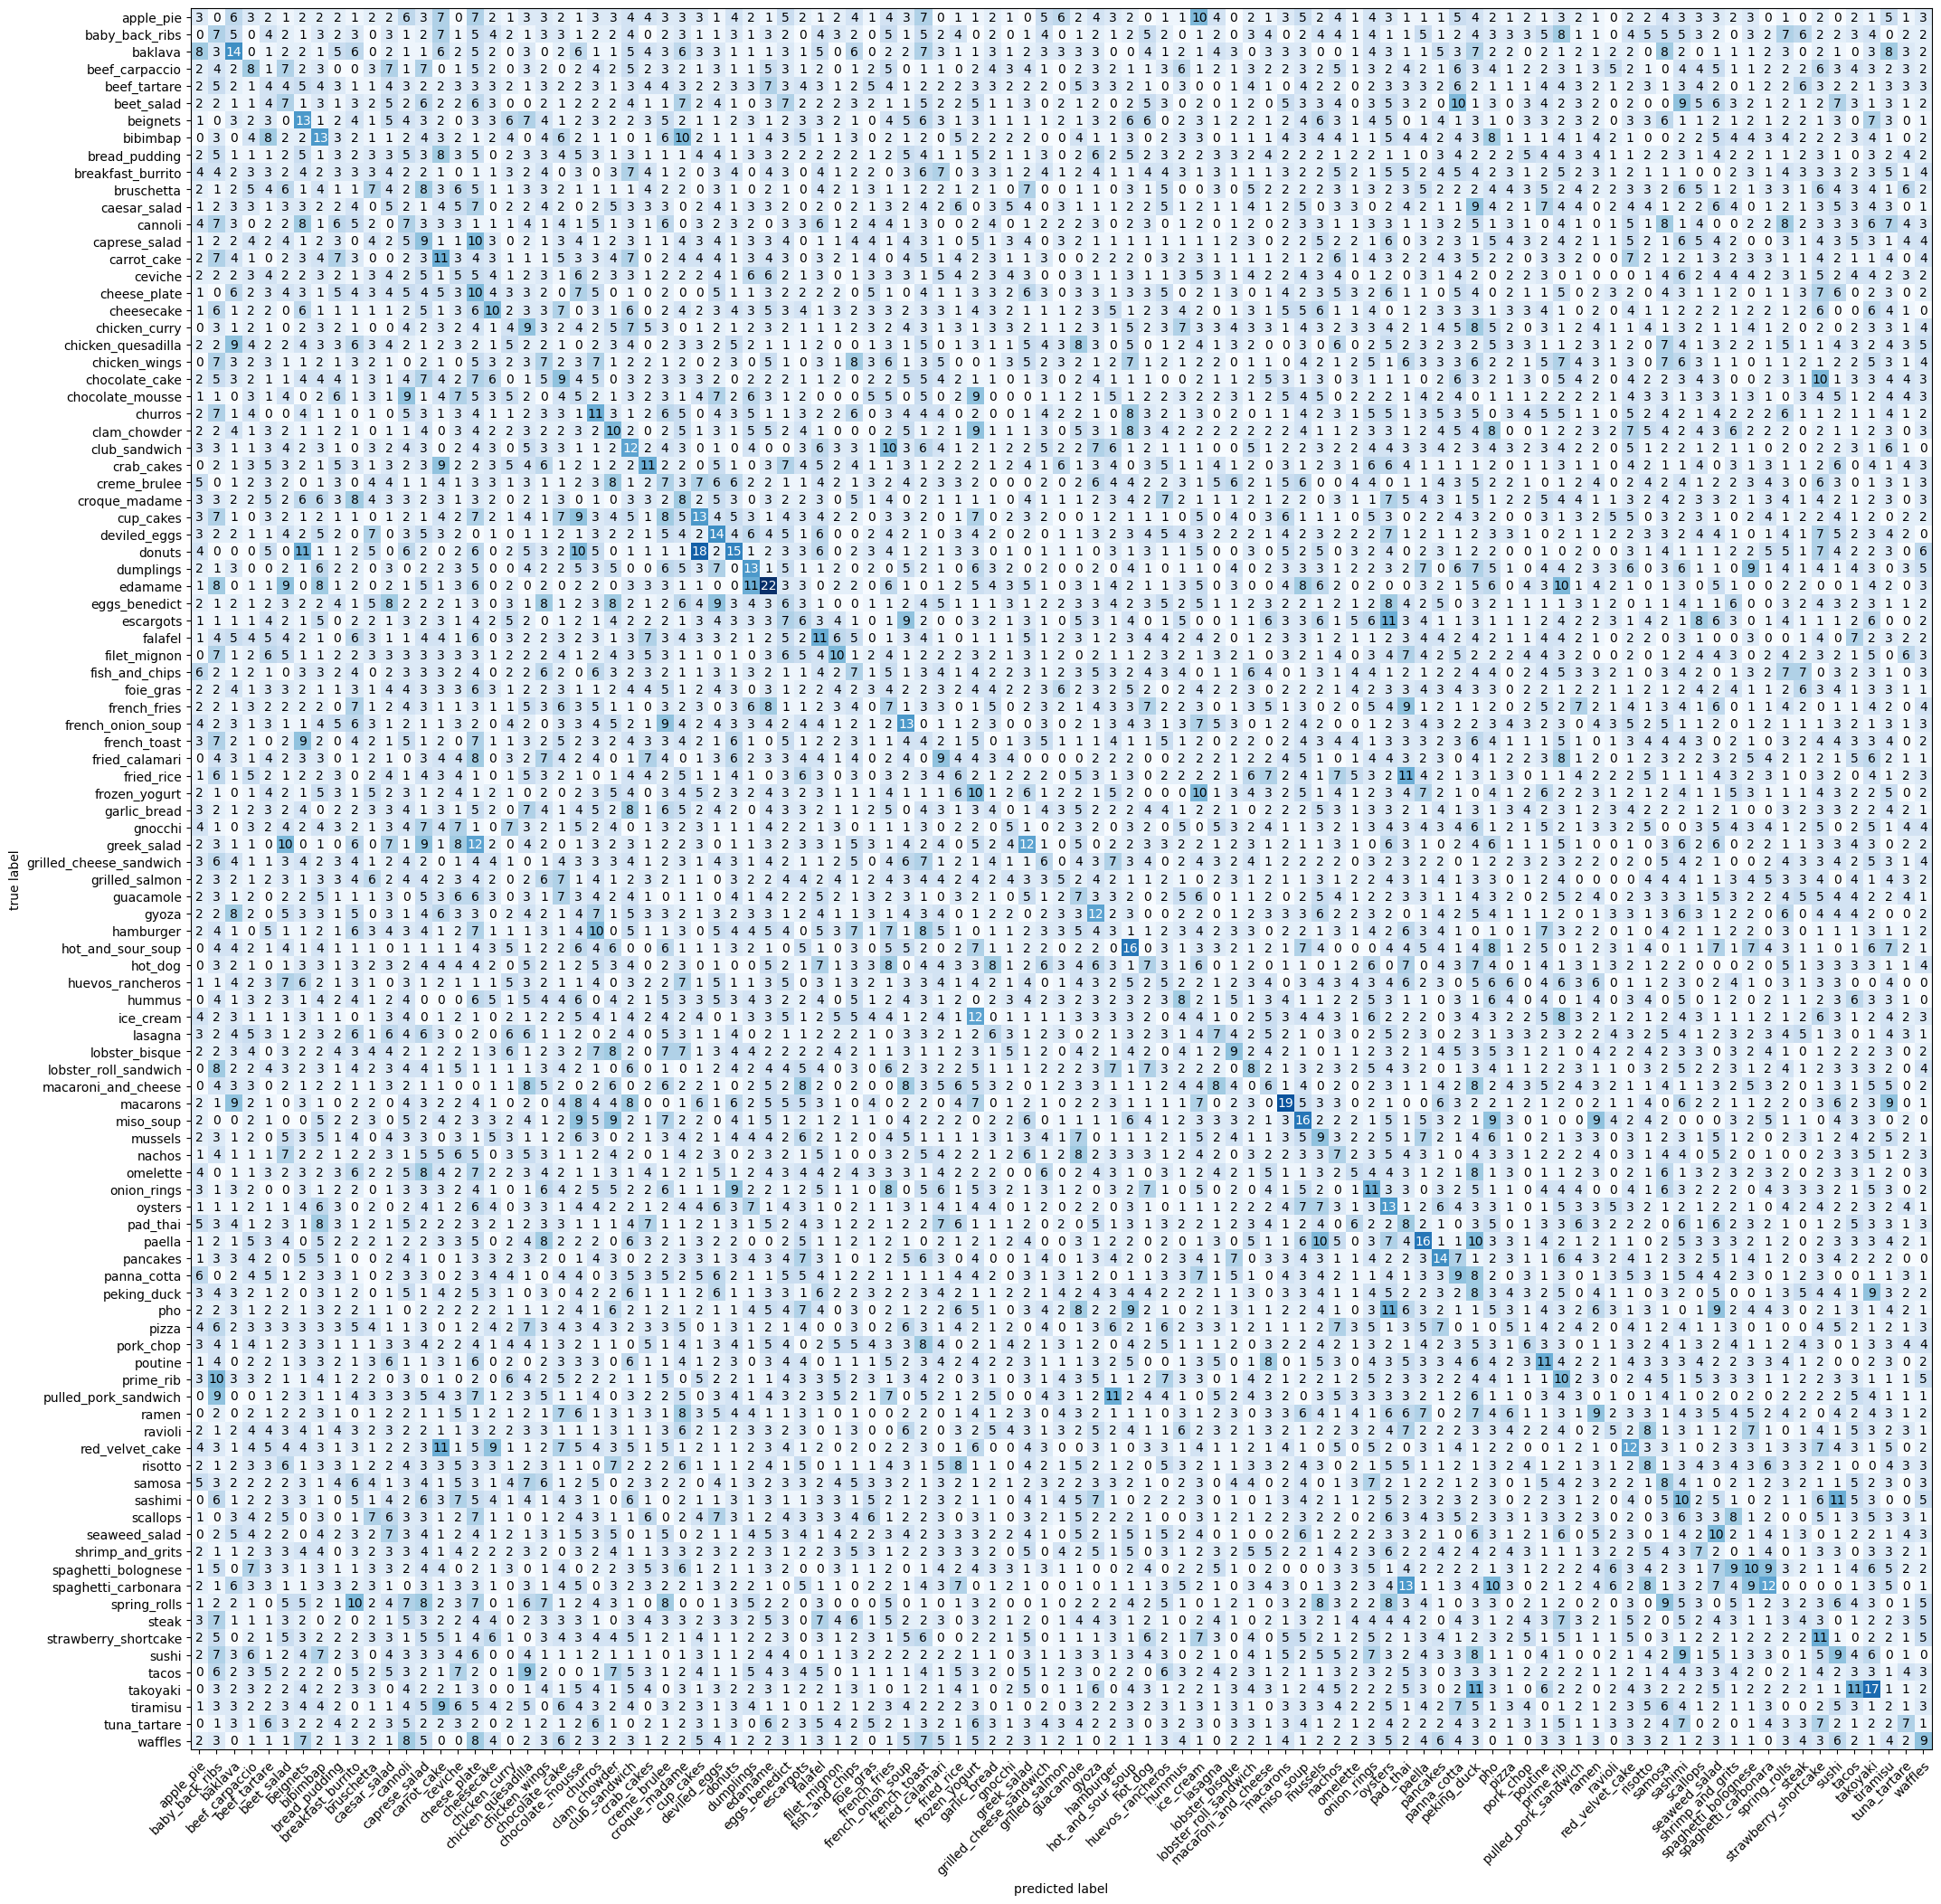

In [54]:
model_resnet50v0_results, confmat_tensor_resnet50v0 = eval_model_CF(model=model_resnet50v0,
                                                                            data_loader = test_dataloader,
                                                                            loss_fn=loss_fn,
                                                                            accuracy_fn= accuracy_fn,
                                                                            test_data = test_data,
                                                                            test_data_targets = test_data_targets,
                                                                            device = device)


fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor_resnet50v0.numpy(),
    class_names=class_names,
    figsize=(25,25))
print(model_resnet50v0_results)

In [55]:
model_efficientnetb0v0 = model

torch.manual_seed(318)
torch.cuda.manual_seed(318)

for param in model_efficientnetb0v0.features.parameters():
    param.requires_grad = False

model_efficientnetb0v0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_efficientnetb0v0.parameters(), lr=1e-3)

torch.manual_seed(318)
torch.cuda.manual_seed(318)

# Measure time
from timeit import default_timer as timer
train_time_start_model_efficientnetb0v0 = timer()

#train and test model
epochs =5
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_step(model=model_efficientnetb0v0,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_efficientnetb0v0,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_efficientnetb0v0 = timer()
total_train_time_model_efficientnetb0v0 = print_train_time(start=train_time_start_model_efficientnetb0v0,
                                               end=train_time_end_model_efficientnetb0v0,
                                               device=device)



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 2.59470 | Train accuracy: 40.17%
Test loss: 1.82828 | Test accuracy: 54.30%

Epoch: 1
Train loss: 2.09442 | Train accuracy: 48.85%
Test loss: 1.72216 | Test accuracy: 56.18%

Epoch: 2
Train loss: 2.00553 | Train accuracy: 50.47%
Test loss: 1.70127 | Test accuracy: 56.73%

Epoch: 3
Train loss: 1.95128 | Train accuracy: 51.62%
Test loss: 1.64560 | Test accuracy: 57.83%

Epoch: 4
Train loss: 1.92756 | Train accuracy: 52.01%
Test loss: 1.66225 | Test accuracy: 57.67%

Train time on cuda: 2385.020 seconds


  0%|          | 0/790 [00:00<?, ?it/s]

{'model_name': 'EfficientNet', 'model_loss': 1.6564627885818481, 'model_acc': 57.66613924050633}


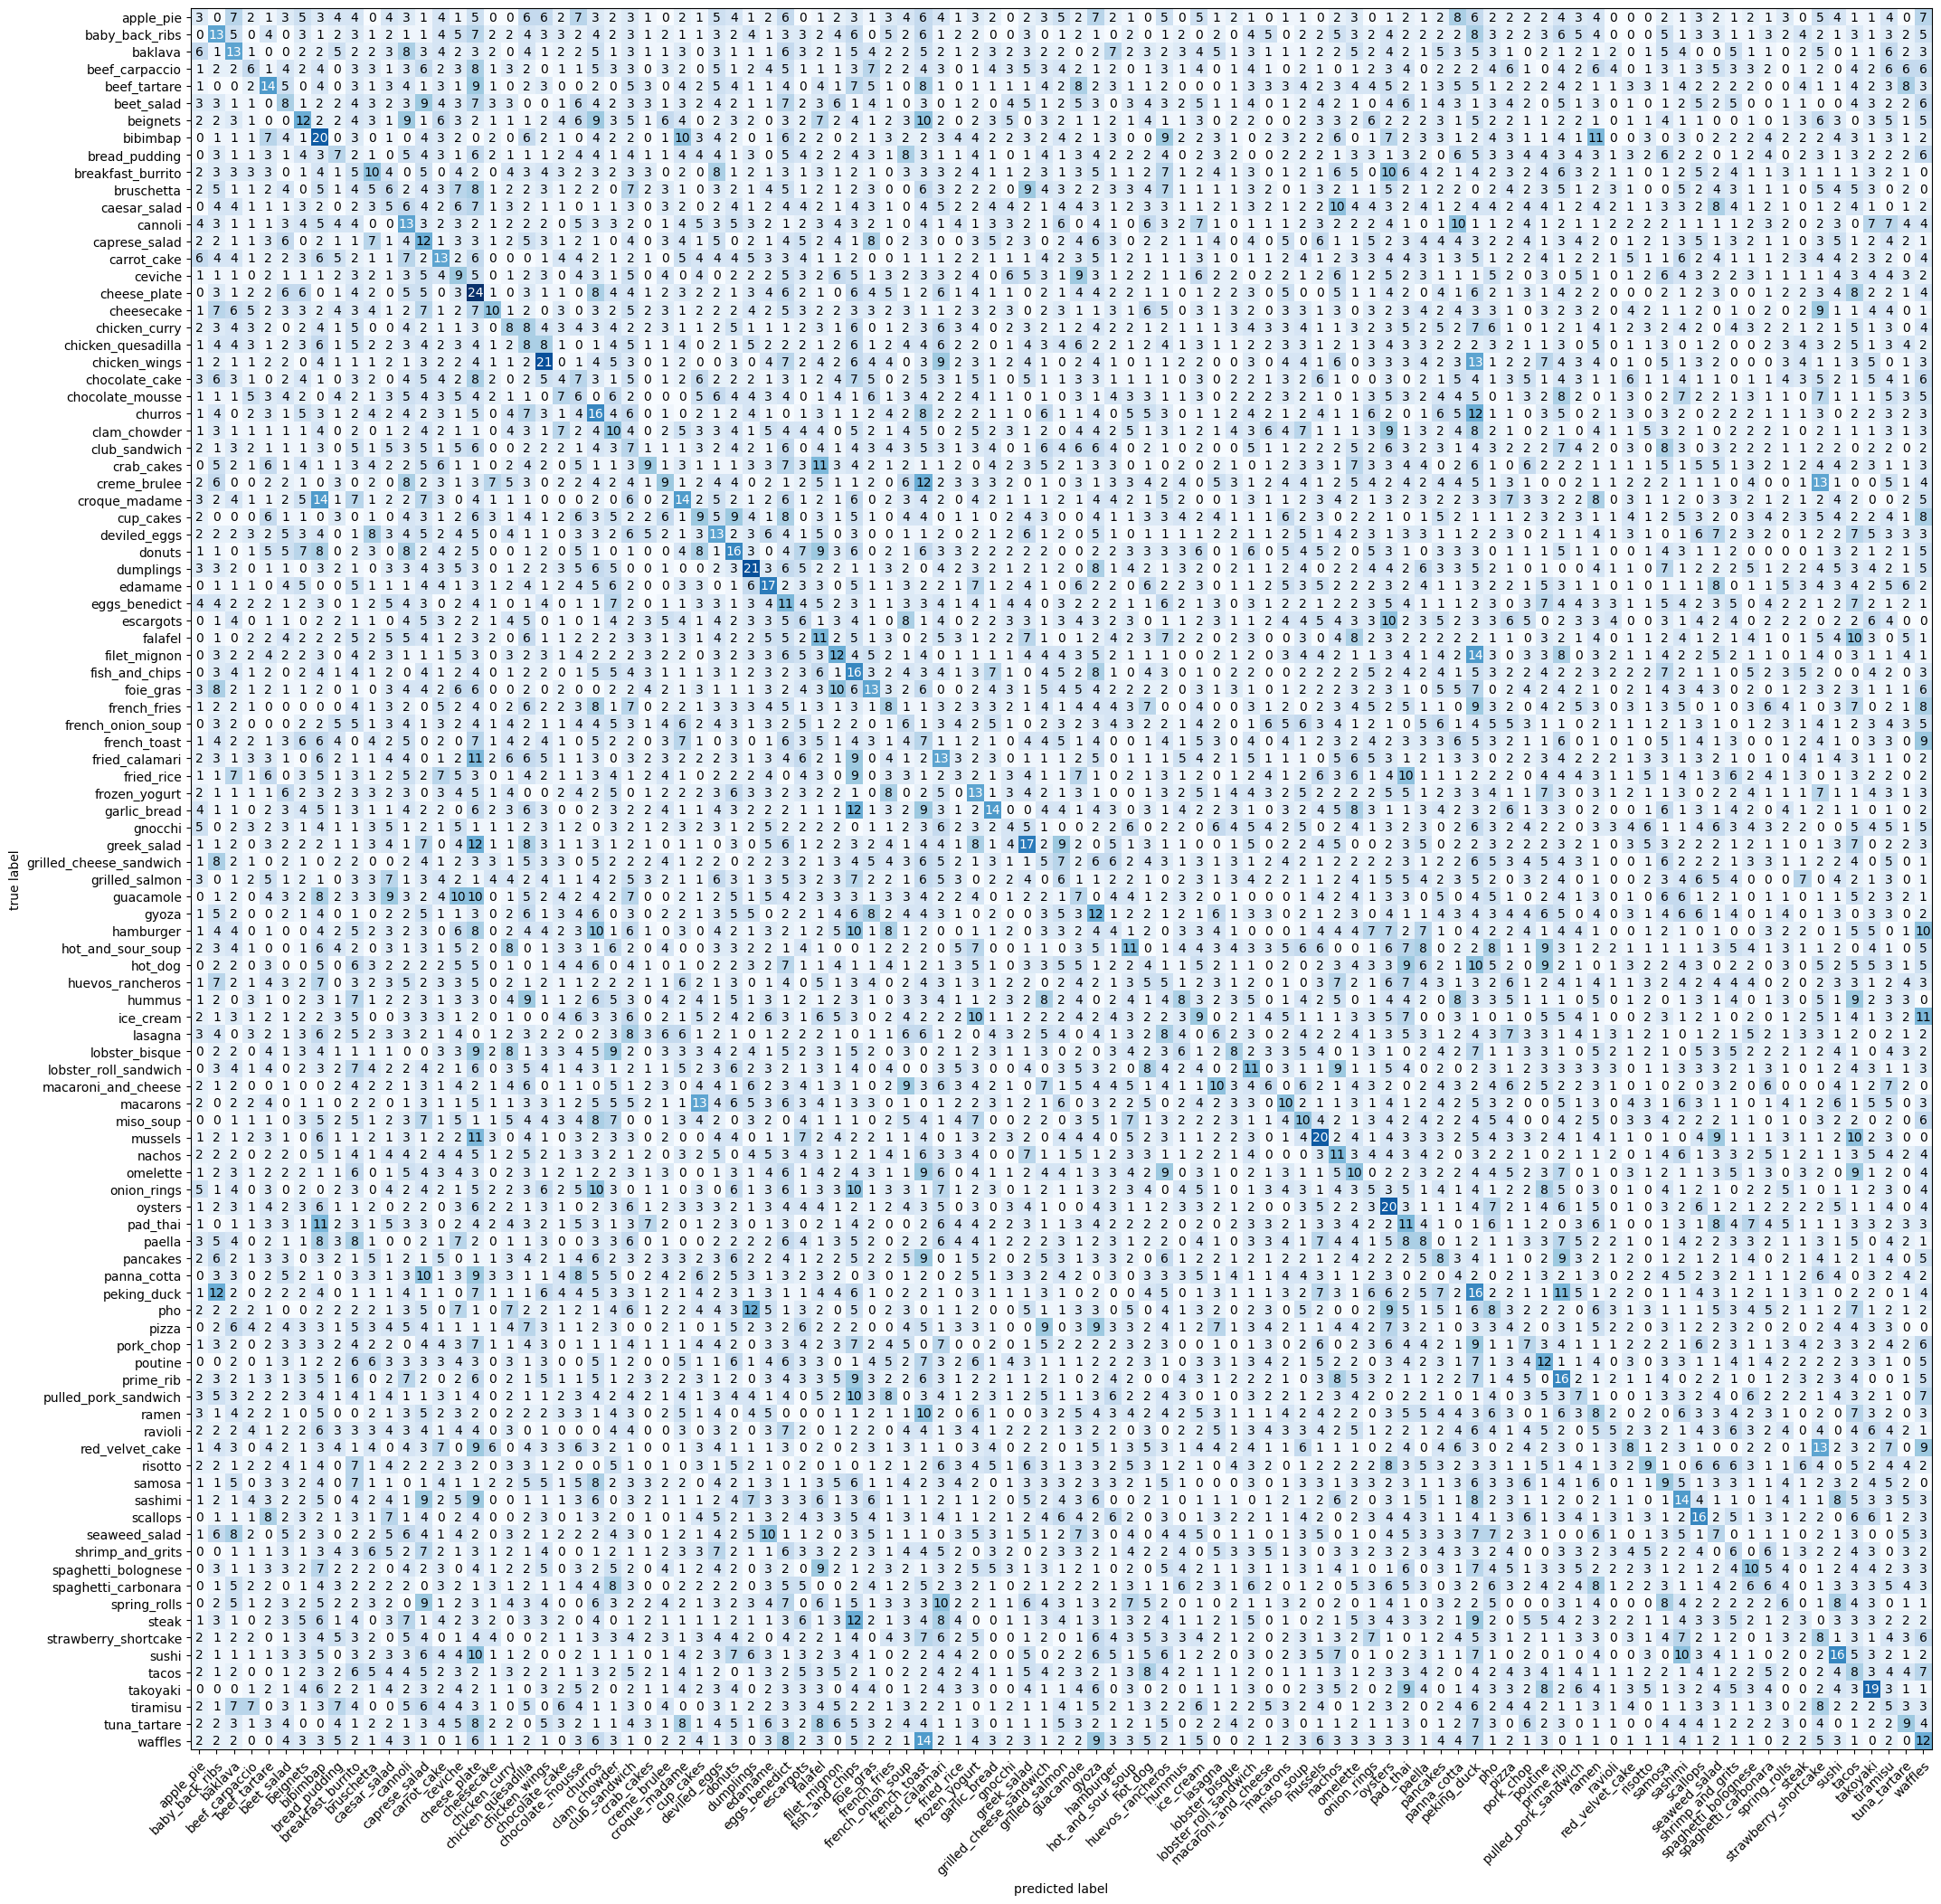

In [56]:
model_efficientnetb0v0_results, confmat_tensor_efficientnetb0v0 = eval_model_CF(model=model_efficientnetb0v0,
                                                                            data_loader = test_dataloader,
                                                                            loss_fn=loss_fn,
                                                                            accuracy_fn= accuracy_fn,
                                                                            test_data = test_data,
                                                                            test_data_targets = test_data_targets,
                                                                            device = device)


fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor_efficientnetb0v0.numpy(),
    class_names=class_names,
    figsize=(25,25))
print(model_efficientnetb0v0_results)

In [57]:
weights = torchvision.models.Inception_V3_Weights.DEFAULT
model_inceptionv3v0 = torchvision.models.inception_v3(weights=weights)

torch.manual_seed(318)
torch.cuda.manual_seed(318)

model_inceptionv3v0.aux_logits = False

for param in model_inceptionv3v0.Conv2d_1a_3x3.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Conv2d_2a_3x3.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Conv2d_2b_3x3.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Conv2d_3b_1x1.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Conv2d_4a_3x3.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Mixed_5b.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Mixed_5c.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Mixed_5d.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Mixed_6a.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Mixed_6b.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Mixed_6c.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Mixed_6d.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Mixed_6e.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Mixed_7a.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Mixed_7b.parameters():
    param.requires_grad = False
for param in model_inceptionv3v0.Mixed_7c.parameters():
    param.requires_grad = False

model_inceptionv3v0.fc = nn.Linear(in_features=2048,
                                 out_features=output_shape
                                 , bias=True).to(device)

from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_inceptionv3v0.parameters(), lr=1e-3)

torch.manual_seed(318)
torch.cuda.manual_seed(318)

# Measure time
from timeit import default_timer as timer
train_time_start_model_inceptionv3v0 = timer()

#train and test model
epochs =5
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_step(model=model_inceptionv3v0,
             data_loader=train_dataloader_iv3,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_inceptionv3v0,
            data_loader=test_dataloader_iv3,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_inceptionv3v0 = timer()
total_train_time_model_inceptionv3v0 = print_train_time(start=train_time_start_model_inceptionv3v0,
                                               end=train_time_end_model_inceptionv3v0,
                                               device=device)



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 2.99120 | Train accuracy: 31.13%
Test loss: 2.06998 | Test accuracy: 49.01%

Epoch: 1
Train loss: 2.56929 | Train accuracy: 39.06%
Test loss: 1.90045 | Test accuracy: 51.72%

Epoch: 2
Train loss: 2.56170 | Train accuracy: 39.60%
Test loss: 1.93757 | Test accuracy: 51.02%

Epoch: 3
Train loss: 2.55242 | Train accuracy: 39.98%
Test loss: 1.87756 | Test accuracy: 52.32%

Epoch: 4
Train loss: 2.55633 | Train accuracy: 40.28%
Test loss: 1.87812 | Test accuracy: 52.59%

Train time on cuda: 2951.350 seconds


  0%|          | 0/790 [00:00<?, ?it/s]

{'model_name': 'Inception3', 'model_loss': 1.8781704902648926, 'model_acc': 52.44857594936709}


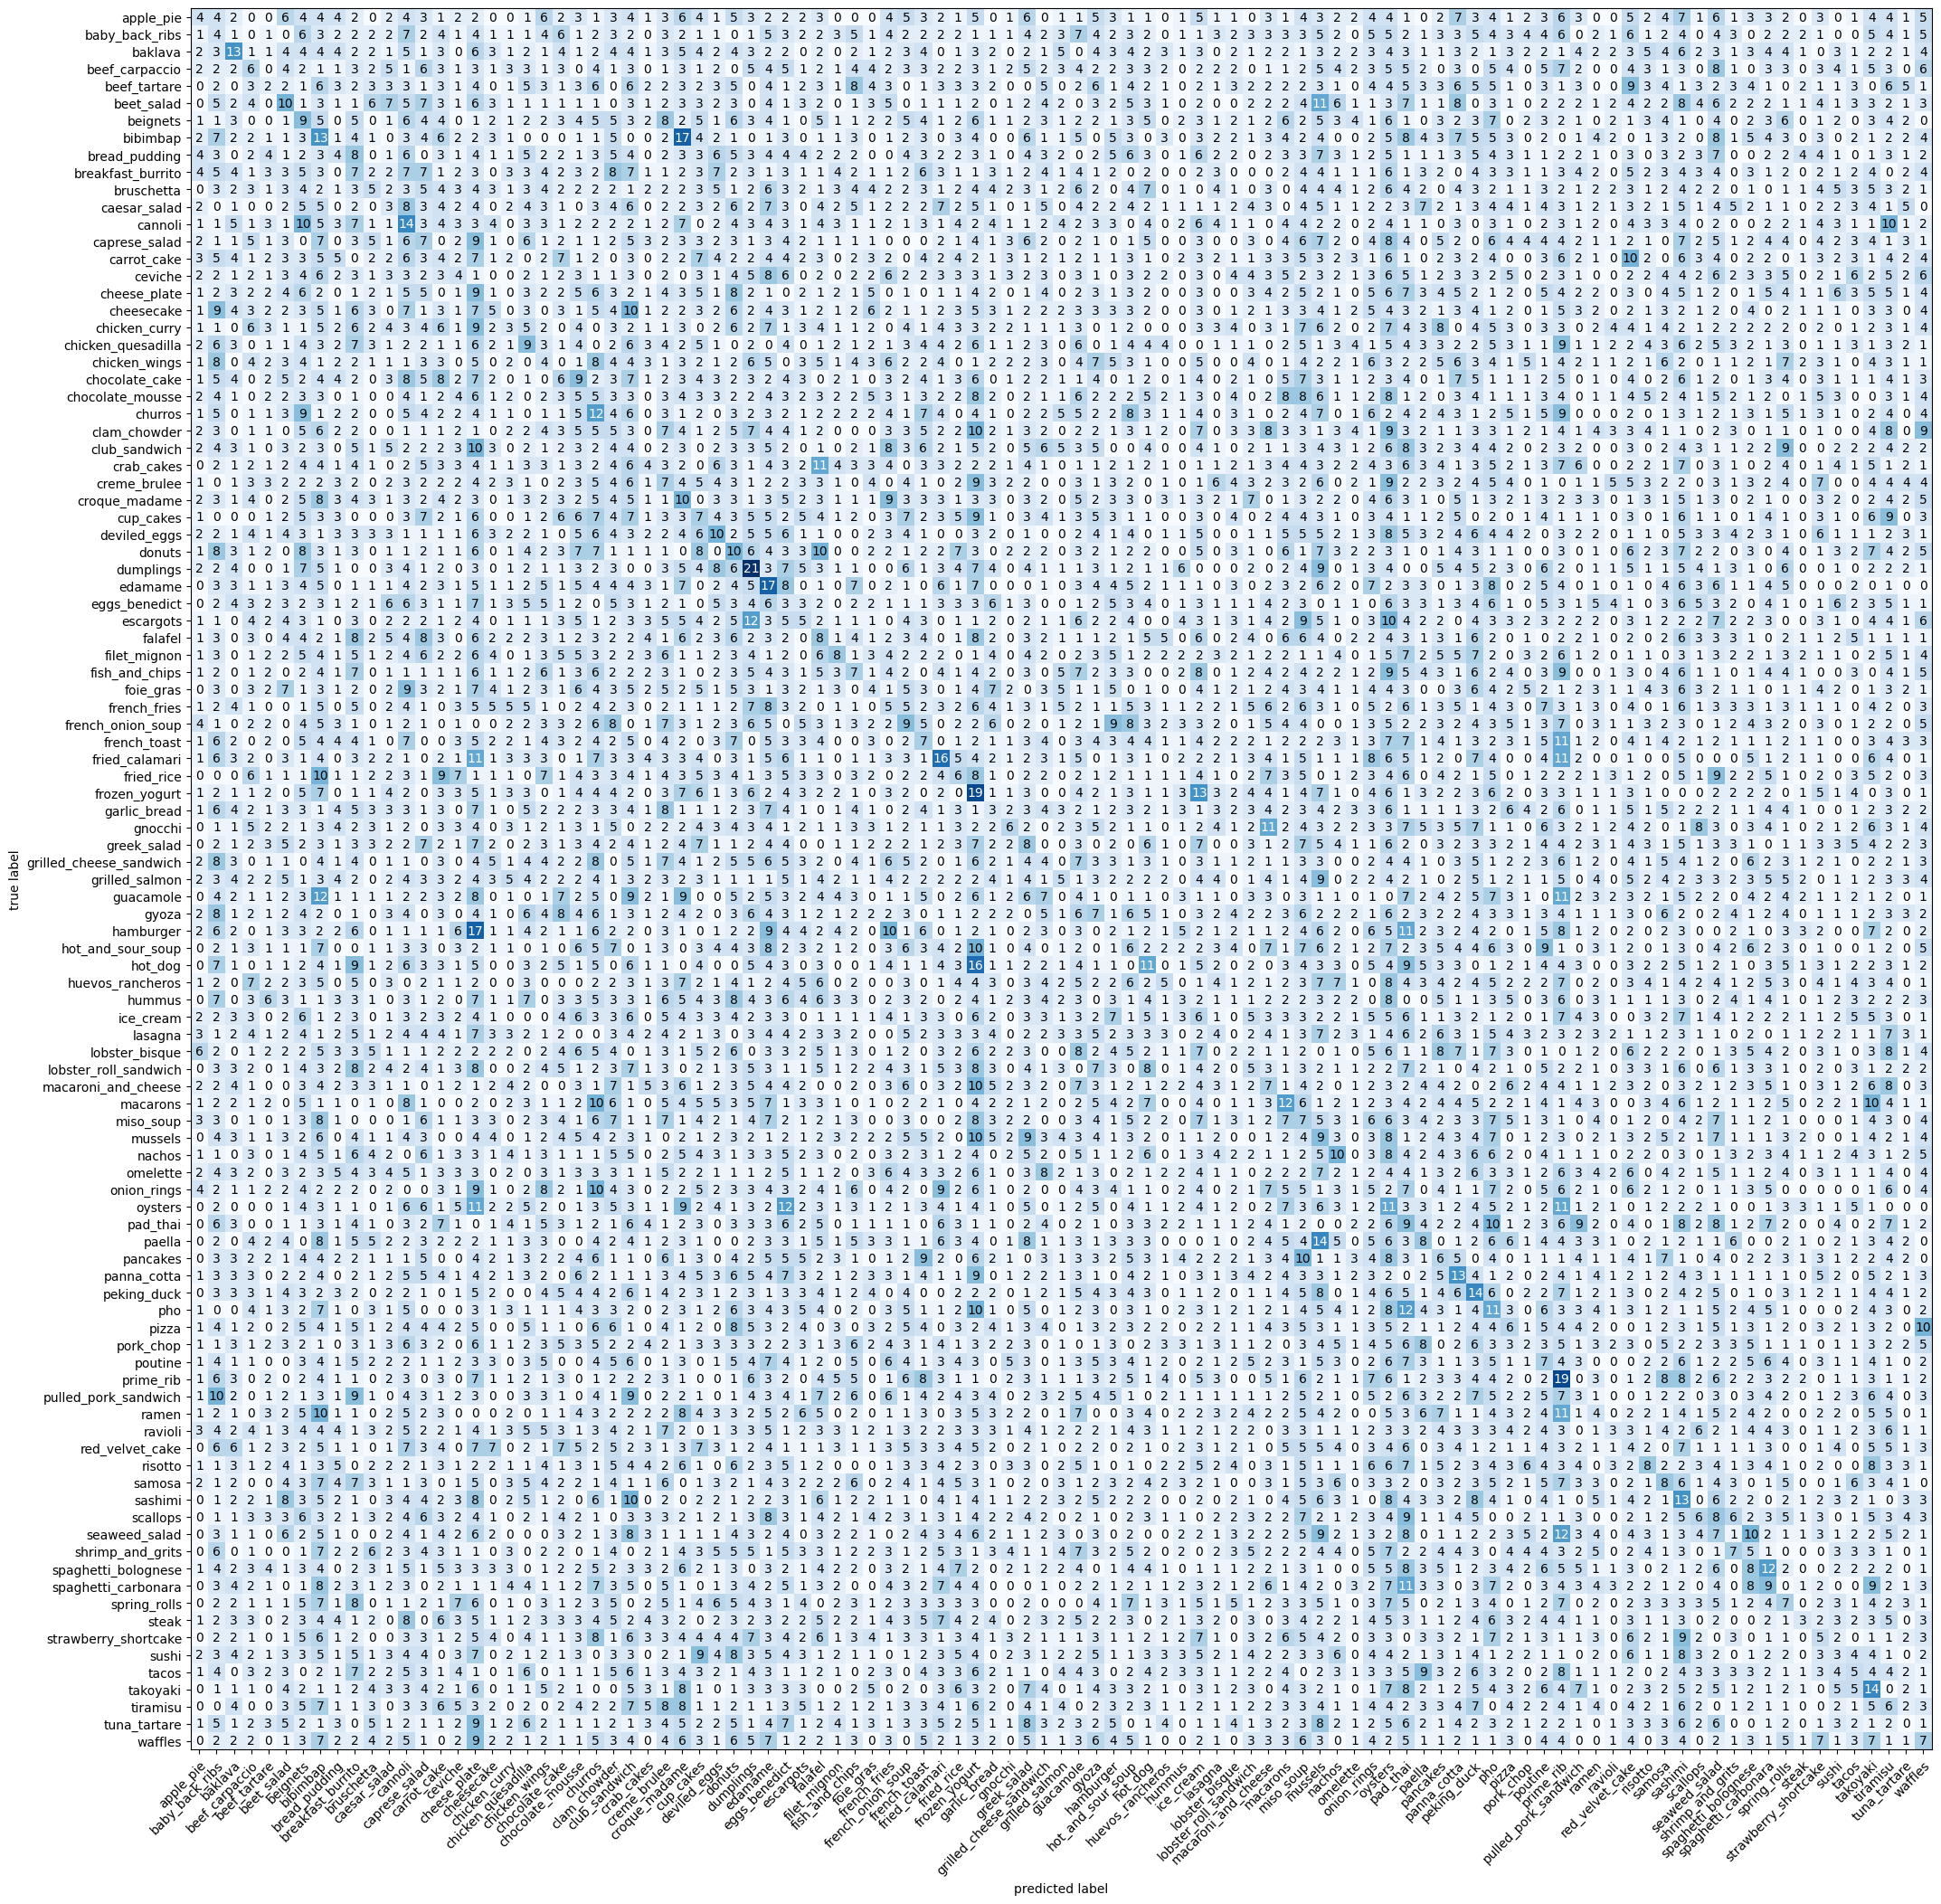

In [58]:
model_inceptionv3v0_results, confmat_tensor_inceptionv3v0 = eval_model_CF(model=model_inceptionv3v0,
                                                                            data_loader = test_dataloader_iv3,
                                                                            loss_fn=loss_fn,
                                                                            accuracy_fn= accuracy_fn,
                                                                            test_data = test_data_iv3,
                                                                            test_data_targets = test_data_targets,
                                                                            device = device)


fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor_inceptionv3v0.numpy(),
    class_names=class_names,
    figsize=(25,25))
print(model_inceptionv3v0_results)

In [60]:
import pandas as pd

result = pd.DataFrame([model_efficientnetb0_results,
              model_efficientnetb0v0_results,
              model_resnet50_results,
              model_resnet50v0_results,
              model_inceptionv3_results,
              model_inceptionv3v0_results])
result["learning_rate"] = [1e-2,1e-3,1e-2,1e-3,1e-2,1e-3]
result

model_name  model_loss  model_acc  learning_rate
0  EfficientNet    3.600573  49.560918          0.010
1  EfficientNet    1.656463  57.666139          0.001
2        ResNet    3.229273  56.712816          0.010
3        ResNet    1.280983  66.190665          0.001
4    Inception3    6.207753  43.184335          0.010
5    Inception3    1.878170  52.448576          0.001

In [61]:
#Saving the model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "Food101_InceptionV3_v1.pth"
MODEL_SAVE_PATH_InceptionV3 = MODEL_PATH/MODEL_NAME

print(f"saving model to: {MODEL_SAVE_PATH_InceptionV3}")
torch.save(obj=model_inceptionv3v0.state_dict(),
           f=MODEL_SAVE_PATH_InceptionV3)

MODEL_NAME = "Food101_EfficientNetB0_v1.pth"
MODEL_SAVE_PATH_EfficientnetB0 = MODEL_PATH/MODEL_NAME

print(f"saving model to: {MODEL_SAVE_PATH_EfficientnetB0}")
torch.save(obj=model_efficientnetb0v0.state_dict(),
           f=MODEL_SAVE_PATH_EfficientnetB0)

MODEL_NAME = "Food101_ResNet50_v1.pth"
MODEL_SAVE_PATH_Resnet50 = MODEL_PATH/MODEL_NAME

print(f"saving model to: {MODEL_SAVE_PATH_Resnet50}")
torch.save(obj=model_resnet50v0.state_dict(),
           f=MODEL_SAVE_PATH_Resnet50)


saving model to: models/Food101_InceptionV3_v1.pth
saving model to: models/Food101_EfficientNetB0_v1.pth
saving model to: models/Food101_ResNet50_v1.pth
